Predicción de gastos médicos en PySpark
===

* *30 min* | Última modificación: Junio 22, 2019

En este tutorial se construyen modelos de regresión para la predicción de gastos médicos por parte de una aseguradora.

Al finalizar este tutorial, usted estará en capacidad de:

* Realizar el análisis exploratorio de datos para aplicar técnicas de regresión.


* Estimar diferentes tipos de modelos de regresión usando PySpark.


## Definición del problema

Una compañía de seguros desea pronósticar los gastos médicos de la población asegurada con el fin de recolectar un valor superior en ingresos, tal que le permita obtener utilidades. Los costos son difíciles de pronósticar ya que las condiciones más costosas son más raras y parecen aleatorias; y que ciertas condiciones son más probables para ciertos segmentos de la población (infarto en personas obesas y cáncer en fumadores).

El objetivo es usar una base de datos con 1338 registros de gastos médicos hipotéticos para pacientes de EU con el fin de estimar los costos para determinados segmentos de la población. La información registrada es la siguiente:

* Age: entero hasta 64.

* Sex: male, female.

* bmi: Body mass index.

* children: entero indicando la cantidad de hijos/dependientes cubiertos por el plan de salud.

* smoker: yes, no.

* region: northest, southeast, southwest, northwest.

* charges: costos.


## Solución

### Preparación

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import findspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

findspark.init()

APP_NAME = "spark-insurance-app"

conf = SparkConf().setAppName(APP_NAME) 
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

### Carga de datos

El primer paso consiste en mover los datos del sistema local de archivos al sistema HDFS para que sean accesibles para Spark.

In [3]:
!wget https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/insurance.csv

--2019-11-15 01:01:08--  https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/insurance.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54288 (53K) [text/plain]
Saving to: 'insurance.csv.1'

insurance.csv.1     100%[===================>]  53.02K  --.-KB/s    in 0.1s    

2019-11-15 01:01:09 (410 KB/s) - 'insurance.csv.1' saved [54288/54288]



In [4]:
##
## Mueve el archivo de datos al hdfs
##
!hdfs dfs -copyFromLocal insurance.csv /tmp/insurance.csv

copyFromLocal: `/tmp/insurance.csv': File exists


Los datos se encuentran almacenados en formato CSV, tal como se muestra a continuación.

In [5]:
!head insurance.csv

age,sex,bmi,children,smoker,region,charges
19,female,27.9,0,yes,southwest,16884.924
18,male,33.77,1,no,southeast,1725.5523
28,male,33,3,no,southeast,4449.462
33,male,22.705,0,no,northwest,21984.47061
32,male,28.88,0,no,northwest,3866.8552
31,female,25.74,0,no,southeast,3756.6216
46,female,33.44,1,no,southeast,8240.5896
37,female,27.74,3,no,northwest,7281.5056
37,male,29.83,2,no,northeast,6406.4107


Los datos son cargados como un DataFrame de Spark; el archivo `insurance.csv` se encuentra en la carpeta `tmp/` del HDFS.

In [6]:
df = spark.read.load(
    "/tmp/insurance.csv",
    format="csv", 
    sep=",", 
    inferSchema="true", 
    header="true")

df.show()

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|
| 60|female| 25.84|       0|    no|northwest|28923.13692|
| 25|  male| 26.22|       0|    no|northeast|  2721.3208|
| 62|female| 26.29|       0|   yes|southeast| 27808.7251|
| 23|  male|  34.4|       0|    no|southwest|   1826.843|
| 56|female| 39.82|       0|    no|southeast| 11090.7178|
| 27|  male| 4

In [7]:
##
## Verificación del esquema de los datos
##
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



In [8]:
##
## Tipo de dato de cada columna
##
df.dtypes

[('age', 'int'),
 ('sex', 'string'),
 ('bmi', 'double'),
 ('children', 'int'),
 ('smoker', 'string'),
 ('region', 'string'),
 ('charges', 'double')]

### Análisis exploratorio

A continuación se presentan algunos estadísticos de interés en el modelado. 

In [9]:
##
## Se obtienen las columnas numéricas
##
num_columns = [a for a,b in df.dtypes if b != 'string']

In [10]:
##
## Estadísticos descriptivos de las variables. 
## Cuando no hay un gran volumen de datos es 
## posible importar el set a Pandas para usar
## sus funciones nativas.
##
df.select(num_columns).describe().toPandas()

summary                 age                 bmi           children  \
0   count                1338                1338               1338   
1    mean   39.20702541106129  30.663396860986538    1.0949177877429   
2  stddev  14.049960379216147   6.098186911679012  1.205492739781914   
3     min                  18               15.96                  0   
4     max                  64               53.13                  5   

              charges  
0                1338  
1  13270.422265141257  
2  12110.011236693992  
3           1121.8739  
4         63770.42801

In [11]:
##
## Cómputo de estadísticos usando funciones
## nativas de pyspark
##

from pyspark.mllib.stat import Statistics

for col_name in num_columns:
    print(col_name)
    summary = Statistics.colStats(df.select(col_name).rdd.map(list))
    print('    Mean:     ', summary.mean()[0])
    print('    Variance: ', summary.variance()[0])
    print('    Nonzeros: ', summary.numNonzeros()[0])
    print()

age
    Mean:      39.20702541106125
    Variance:  197.40138665754355
    Nonzeros:  1338.0

bmi
    Mean:      30.663396860986524
    Variance:  37.18788360977321
    Nonzeros:  1338.0

children
    Mean:      1.0949177877428995
    Variance:  1.4532127456669042
    Nonzeros:  764.0

charges
    Mean:      13270.422265141255
    Variance:  146652372.15285477
    Nonzeros:  1338.0



In [12]:
##
## Se obtienen las columnas no numéricas y
## se computa la cantidad de registros por 
## valor. Aca se emula la función table del
## lenguaje R.
##
no_num_columns = [a for a,b in df.dtypes if b == 'string']

In [13]:
for column_name in no_num_columns:
    print(df.groupBy(column_name).count().toPandas())
    print()

      sex  count
0  female    662
1    male    676

  smoker  count
0     no   1064
1    yes    274

      region  count
0  northwest    325
1  southeast    364
2  northeast    324
3  southwest    325



In [14]:
##
## histograma.
## Muestra que la mayor parte de la población tiene 
## gastos bajos, mientras que disminuye la frecuencia
## de costos más altos es más baja.
##
## La función histogram de pyspark permite computar
## los datos de graficación del histograma, pero
## no grafica el histograma como tal.
##
h = df.select('charges').rdd.flatMap(lambda x: x).histogram(11)
h

([1121.8739,
  6817.197000909091,
  12512.520101818183,
  18207.843202727272,
  23903.166303636364,
  29598.489404545457,
  35293.812505454545,
  40989.13560636364,
  46684.45870727273,
  52379.78180818182,
  58075.104909090915,
  63770.42801],
 [492, 383, 152, 93, 56, 32, 61, 42, 21, 2, 4])

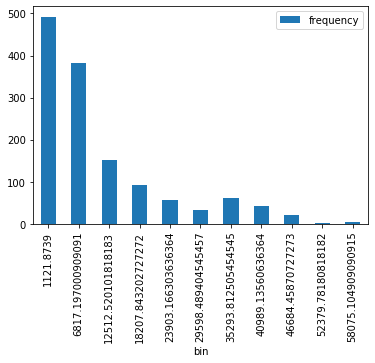

In [15]:
##
## Debe recurrise a Pandas para realizar la
## graficación
##
pd.DataFrame(
    list(zip(*h)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

In [16]:
##
## Cómputo de la correlación entre
## las variables numéricas del DataFrame
##
Statistics.corr( 
    ##
    ## Se deben seleccionar únicamente las columnas 
    ## numéricas y luego transformar el rdd
    ##
    df.select(num_columns).rdd.map(lambda row: row[0:]), 
    method='pearson')

array([[1.        , 0.10927188, 0.042469  , 0.29900819],
       [0.10927188, 1.        , 0.0127589 , 0.19834097],
       [0.042469  , 0.0127589 , 1.        , 0.06799823],
       [0.29900819, 0.19834097, 0.06799823, 1.        ]])

Aunque Spark tiene funciones para el análisis de datos, no posee ninguna herramienta para la graficación de información, por lo que la mayor parte de los análisis deben realizarse de forma estándar en Python. Para ello, es necesario utilizar la función `toPandas()` que permite un DataFrame de Spark a un DataFrame de Pandas.

En la siguiente celda se contruye una grafica tipo `pair` para analizar la información entre variables.

In [17]:
!pip3 install seaborn

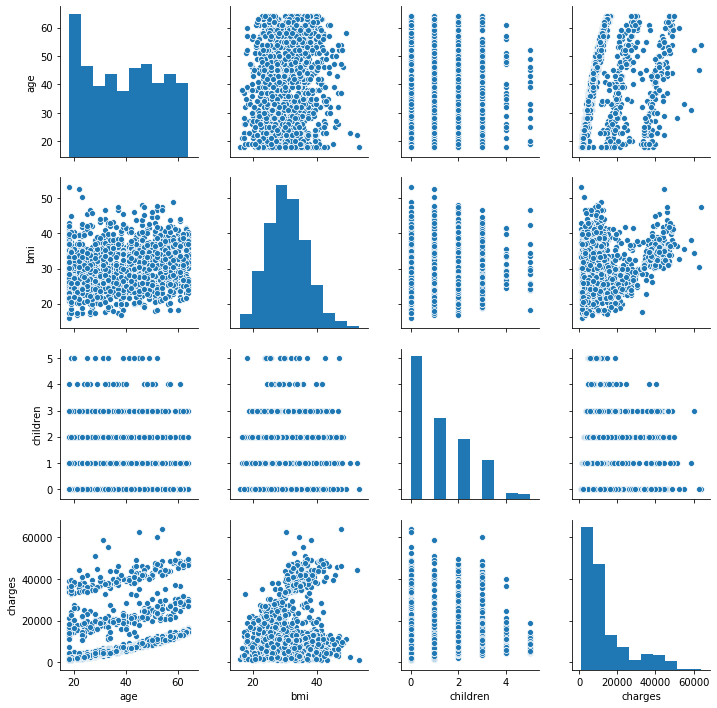

In [18]:
import seaborn as sns
sns.pairplot(data = df.toPandas());

### Transformación de variables

De acuerdo con la información obtenida en el esquema:

In [19]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



Las variables `sex`, `smoker` y `region` son categóricas por lo que deben ser codificadas como factores. Esta tarea es realizada usando la función `StringIndexer`. Los resultados de las transformaciones son visualizados al final, con la función `show()`. 

In [20]:
from pyspark.ml.feature import StringIndexer

##
## outputCol es el nombre de la nueva columna que contiene 
## el resultado de la codificación como factor
##
df = StringIndexer(inputCol = 'sex',    outputCol = 'sexIdx').fit(df).transform(df)
df = StringIndexer(inputCol = 'smoker', outputCol = 'smokerIdx').fit(df).transform(df)
df = StringIndexer(inputCol = 'region', outputCol = 'regionIdx').fit(df).transform(df)

df.show()

+---+------+------+--------+------+---------+-----------+------+---------+---------+
|age|   sex|   bmi|children|smoker|   region|    charges|sexIdx|smokerIdx|regionIdx|
+---+------+------+--------+------+---------+-----------+------+---------+---------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|   1.0|      1.0|      1.0|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|   0.0|      0.0|      0.0|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|   0.0|      0.0|      0.0|
| 33|  male|22.705|       0|    no|northwest|21984.47061|   0.0|      0.0|      2.0|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|   0.0|      0.0|      2.0|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|   1.0|      0.0|      0.0|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|   1.0|      0.0|      0.0|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|   1.0|      0.0|      2.0|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|   0.0| 

### Estimación de los modelos de regresión

#### Preparación de los regresores

A continuación se procede a la construcción de los modelos de regresión considerados. En primera instancia, se procede a realizar una transformación adicional del DataFrame con la función `VectorAssembler()`, con el fin de crear la nueva columna `features` que contiene una lista con los valores de las variables indicadas en el parámetro `inputCols`. Note que `outputCol` hace referencia al nombre de la nueva columna que se está creando en el DataFrame. El resultado de la transformación puede verse en la salida de la siguiente celda: 

In [21]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(
    inputCols = ['age', 'bmi', 'children', 'sexIdx', 'smokerIdx', 'regionIdx'],
    outputCol = 'features')

df = vectorAssembler.transform(df)

df.show()

+---+------+------+--------+------+---------+-----------+------+---------+---------+--------------------+
|age|   sex|   bmi|children|smoker|   region|    charges|sexIdx|smokerIdx|regionIdx|            features|
+---+------+------+--------+------+---------+-----------+------+---------+---------+--------------------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|   1.0|      1.0|      1.0|[19.0,27.9,0.0,1....|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|   0.0|      0.0|      0.0|[18.0,33.77,1.0,0...|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|   0.0|      0.0|      0.0|[28.0,33.0,3.0,0....|
| 33|  male|22.705|       0|    no|northwest|21984.47061|   0.0|      0.0|      2.0|[33.0,22.705,0.0,...|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|   0.0|      0.0|      2.0|[32.0,28.88,0.0,0...|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|   1.0|      0.0|      0.0|[31.0,25.74,0.0,1...|
| 46|female| 33.44|       1|    no|southeast| 

#### Modelo de regresión lineal

Para realizar la construcción del modelo de regresión se usa la función `LinearRegression` de PySpark. Como ya es característico en otras  librerías tal como en `Sklearn`, primero se crea el modelo dando valores a los parámetros, tales como el número máximo de iteraciones, para posteriormente, usar la función `fit` y realizar la estimación de sus parámetros óptimos.

Para realizar el pronóstico se utiliza la función `transform()` la cual recibe como parámetro un DataFrame que contiene la misma columna en que se hizo la agregación con la función `VectorAssembler()`; `transform()` crea una nueva columna, cuyo nombre es especificado en el parámetro `predictionCol`, que contiene la predicción para cada punto del DataFrame. 

In [22]:
from pyspark.mllib.evaluation import RegressionMetrics as rmtrcs
from pyspark.ml.regression import LinearRegression

##
## Se parametriza el modelo
##
lr =  LinearRegression(
    featuresCol = 'features', 
    labelCol = 'charges',
    predictionCol = 'LR',
    maxIter = 100,
    regParam = 0.0,
    elasticNetParam = 0.0,
    fitIntercept=True,
    standardization=True
)

## Se estiman los parámetros óptimos
model = lr.fit(df)

## Se pronostica para los datos originales.
## El pronóstico se agrega a la columna LR
df = model.transform(df)

## Se computan las métricas de ajuste
metrics_lr = rmtrcs(df.rdd.map(lambda x: (x.charges, x.LR)))

print('r2  : ', metrics_lr.r2)
print('MSE : ', metrics_lr.meanSquaredError)
print('MAD : ', metrics_lr.meanAbsoluteError)

r2  :  0.6681376677254415
MSE :  36514302.63326162
MAD :  4170.809292696869


#### DecisionTreeRegressor

A continuación se construye un arbol de decisión para regresión.

In [23]:
from pyspark.ml.regression import DecisionTreeRegressor

##
## Se parametriza el modelo
##
dt = DecisionTreeRegressor(
    featuresCol='features',
    labelCol='charges',
    predictionCol = 'DTR',
    maxDepth=5,
    maxBins=32,
    seed=1
)

## Ajuste del modelo
model = dt.fit(df)

## Pronostico
df = model.transform(df)

## Métricas de ajuste
metrics_dtr = rmtrcs(df.rdd.map(lambda x: (x.charges, x.DTR)))

print('r2  : ', metrics_dtr.r2)
print('MSE : ', metrics_dtr.meanSquaredError)
print('MAD : ', metrics_dtr.meanAbsoluteError)

r2  :  0.859483711017578
MSE :  18054670.436371412
MAD :  2412.504306482964


#### Random Forest Regression

In [24]:
from pyspark.ml.regression import RandomForestRegressor

##
## Se parametriza el modelo
##
rfr = RandomForestRegressor(
    featuresCol='features',
    labelCol='charges',
    predictionCol = 'RFR',
    maxDepth=5,
    maxBins=32,
    seed=1,
    numTrees = 20
)

## Ajuste del modelo
model = rfr.fit(df)

## Pronóstico
df = model.transform(df)

## Métricas de ajuste
metrics_rfr = rmtrcs(df.rdd.map(lambda x: (x.charges, x.RFR)))

print('r2  : ', metrics_rfr.r2)
print('MSE : ', metrics_rfr.meanSquaredError)
print('MAD : ', metrics_rfr.meanAbsoluteError)

r2  :  0.7140255287048332
MSE :  23952191.959351715
MAD :  3357.8216560466344


#### Gradient-boosted tree regression

In [25]:
from pyspark.ml.regression import GBTRegressor

##
## Se parametriza el modelo
##
gbtr = GBTRegressor(
    featuresCol='features',
    labelCol='charges',
    predictionCol = 'GBTR',
    maxDepth=5,
    maxBins=32,
    maxIter = 20,
    seed=1
)

## Ajuste del modelo
model = gbtr.fit(df)

## Pronóstico
df = model.transform(df)

## Métricas de ajuste
metrics_gbtr = rmtrcs(df.rdd.map(lambda x: (x.charges, x.GBTR)))

print('r2  : ', metrics_gbtr.r2)
print('MSE : ', metrics_gbtr.meanSquaredError)
print('MAD : ', metrics_gbtr.meanAbsoluteError)

r2  :  0.9039753234577255
MSE :  12676112.486827934
MAD :  1998.1260184463802


Finalmente, se extraen los tres pronósticos del modelo y se grafican los pronósticos versus el valor real de la variable explicada.

In [26]:
pdDF = df.select(['charges', 'LR', 'DTR', 'RFR', 'GBTR']).toPandas()
pdDF.head()

charges            LR           DTR           RFR          GBTR
0  16884.92400  25496.991252  16624.369270  18145.012692  17437.411794
1   1725.55230   3350.062141   4240.291099   6063.952809   4516.309085
2   4449.46200   6601.363365   4240.291099   7529.105949   4899.246010
3  21984.47061   3698.003420  10647.618770   5768.849753  12785.938642
4   3866.85520   5544.707716   4231.707560   5332.599745   2795.617415

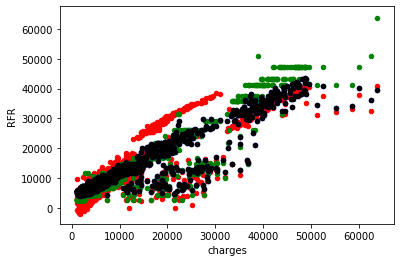

In [27]:
ax = pdDF.plot.scatter('charges', 'LR',  color='red')
pdDF.plot.scatter('charges', 'DTR', color='green', ax=ax)
pdDF.plot.scatter('charges', 'RFR', color='blue',  ax=ax)
pdDF.plot.scatter('charges', 'RFR', color='black', ax=ax);